In [14]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import random_split
from gnn import LPGCN
from linear_program import gen_data

In [15]:
#Definindo os parâmetros do modelo
#Número de restrições do programa linear
num_constraints = 2
#Número de variáveis de decisão do programa linear
num_variables = 4
#Número de problemas em cada conjunto
batch_size = 2
#
learning_rate = 0.003
#Número de conjuntos de problemas lineares a serem gerados
num_data = 10


device = device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
epochs = 50

In [16]:
def train(train_data, val_data, out_func, epochs, num_constraints, num_variables):
    #Inicializando o modelo, a função de perda e o otimizador
    model = LPGCN(num_constraints, num_variables).to(device)
    criterion = nn.MSELoss() #Função de perda é o erro quadrático médio
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Atualiza os parâmetros do modelo com learning rate=0.001

    train_loss = []
    val_loss = []

    #Função auxiliar para desempacotar os dados
    def unpack_vars(data):
        c, A, b, constraints, l, u, sol, feas, edge_index = data
        c = c.to(device)
        A = A.to(device)
        b = b.to(device)
        constraints = constraints.to(device)
        l = l.to(device)
        u = u.to(device)
        sol = sol.to(device)
        return c, A, b, constraints, l, u, sol, feas, edge_index

    # optimize parameters and calculates training loss
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        for dataloader in train_data:
            for batch in dataloader:
                optimizer.zero_grad()
                c, A, b, constraints, l, u, sol, feas, edge_index = unpack_vars(batch)
                #chamando a função forward do modelo LPGCN
                out = model(c, A, b, constraints, l, u, edge_index, out_func) 

                #Calculando a perda    
                if out_func == 'feas':
                    loss = (out.shape[0] - torch.sum(torch.eq(out, feas))) / out.shape[0]
                elif out_func == 'obj':
                    loss = criterion(out[:,0], torch.sum(c * sol, dim=1))
                else:
                    loss = criterion(out, sol)

                if out_func != 'feas':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()

        train_loss += [running_loss]

        # backup of optimized parameters
        if not os.path.exists(f'model_{out_func}_backups'):
            os.makedirs(f'model_{out_func}_backups')

        torch.save(model, f'model_{out_func}_backups/model_{out_func}_{epoch}.pt')
        
        # calculates validation error
        running_loss = 0.0

        for dataloader in val_data:
            for batch in dataloader:
                c, A, b, constraints, l, u, sol, feas, edge_index = unpack_vars(batch)
                out = model(c, A, b, constraints, l, u, edge_index, out_func)

                if out_func == 'feas':
                    loss = (out.shape[0] - torch.sum(torch.eq(out, feas))) / out.shape[0]

                elif out_func == 'obj':
                    loss = criterion(out[:,0], torch.sum(c * sol, dim=1))

                else:
                    loss = criterion(out, sol)

                running_loss += loss.item()

        val_loss += [running_loss]

    return train_loss, val_loss

In [17]:
out_func = 'obj'

#Conjunto de treinamento contendo 70% dos dados
train_set_obj = gen_data(int(num_data*0.7), batch_size, num_variables, num_constraints, out_func)

train_size = int(0.7 * len(train_set_obj))
validation_size = len(train_set_obj) - train_size

#Dividindo o conjunto de treinamento em treinamento e validação
train_set_obj, val_set_obj = random_split(train_set_obj, [train_size, validation_size])

#Criando o conjunto de teste contendo 30% dos dados
test_data_obj = gen_data(int(num_data*0.3), batch_size, num_variables, num_constraints, out_func)

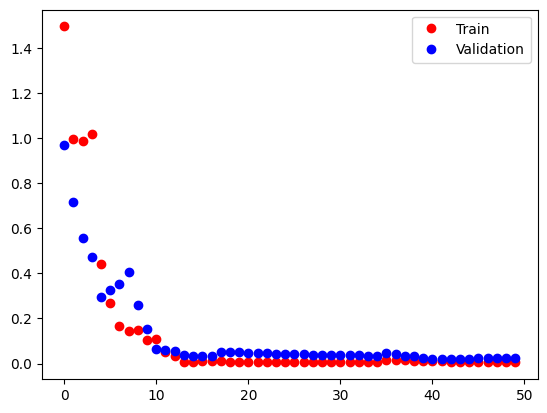

In [18]:
train_loss, val_loss = train(train_set_obj, val_set_obj, out_func, epochs, num_constraints, num_variables)


x = [i for i in range(epochs)]

plt.plot(x, train_loss, 'o', color='red')
plt.plot(x, val_loss, 'o', color='blue')
plt.legend(['Train', 'Validation'])
plt.show()

O gráfico que você forneceu mostra as perdas de treinamento (vermelho) e validação (azul) ao longo de 50 épocas. Vamos analisar o comportamento das curvas e o que isso pode indicar sobre o treinamento do modelo:

1. **Perda Inicial Alta**:
   - No início do treinamento (épocas iniciais), as perdas são altas para ambos os conjuntos de treinamento e validação. Isso é esperado, pois o modelo está começando a aprender e ajustar seus parâmetros.

2. **Redução Rápida das Perdas**:
   - As perdas caem rapidamente nas primeiras 10-15 épocas, indicando que o modelo está aprendendo efetivamente e ajustando seus parâmetros para melhor se adequar aos dados.

3. **Estabilização das Perdas**:
   - Após a redução inicial, as perdas começam a estabilizar em valores baixos, com pequenas oscilações. Isso sugere que o modelo está se aproximando de um mínimo local e refinando seus parâmetros.

4. **Pequenas Oscilações**:
   - As pequenas oscilações nas perdas, especialmente na validação, são normais e podem ocorrer devido à variação nos dados de validação ou pequenas atualizações nos pesos do modelo.

### Conclusões

- **Bom Desempenho de Treinamento**:
  - A perda de treinamento (vermelha) continua a diminuir e estabiliza em um valor baixo, indicando que o modelo está aprendendo bem com os dados de treinamento.

- **Bom Desempenho de Validação**:
  - A perda de validação (azul) também diminui e estabiliza em um valor similar à perda de treinamento. Isso indica que o modelo generaliza bem para novos dados que não foram vistos durante o treinamento.

- **Ausência de Overfitting ou Underfitting Significativo**:
  - Não há uma diferença significativa entre as curvas de treinamento e validação. Se a perda de validação fosse significativamente maior do que a de treinamento, isso indicaria overfitting. Se ambas as perdas fossem altas e não diminuíssem, isso indicaria underfitting. O gráfico atual não mostra nenhum desses problemas.

Portanto, o gráfico indica que o modelo está treinando de forma eficaz e generalizando bem para os dados de validação, o que é um sinal positivo para o desempenho do modelo.

In [19]:
opt_idx = val_loss.index(min(val_loss))
opt_model = torch.load(f'model_{out_func}_backups/model_{out_func}_{opt_idx}.pt').to('cpu')
opt_idx

40

Esse código identifica a melhor época de treinamento baseada na perda de validação, carrega o modelo treinado correspondente a essa época, move-o para a CPU e retorna o índice da época ótima. Isso permite utilizar o melhor modelo encontrado durante o treinamento para avaliação ou inferência em novos dados.

In [20]:
running_loss = 0.0
objs = []
for dataloader in test_data_obj:
    for batch in dataloader:
        c, A, b, constraints, l, u, sol, feas, edge_index = batch
        out = opt_model(c, A, b, constraints, l, u, edge_index, out_func)
        objs.append(torch.sum(c * sol, dim=1))
        loss = torch.mean(torch.square(out[:,0].T - torch.sum(c * sol, dim=1))) ** 1/2

        running_loss += loss.item()

running_loss / int(num_data*0.3)

C:\Users\sofia\AppData\Local\Temp\ipykernel_23536\2649555074.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3679.)
  loss = torch.mean(torch.square(out[:,0].T - torch.sum(c * sol, dim=1))) ** 1/2


0.017318342812359333

In [21]:
for dataloader in test_data_obj:
    for batch in dataloader:
        c, A, b, constraints, l, u, sol, feas, edge_index = batch
        out = opt_model(c, A, b, constraints, l, u, edge_index, out_func)
        print(out[0], torch.sum((c * sol)[0]))
        break

tensor([-0.3276], grad_fn=<SelectBackward0>) tensor(0.0029)
tensor([0.0044], grad_fn=<SelectBackward0>) tensor(-0.0103)
tensor([-0.0475], grad_fn=<SelectBackward0>) tensor(0.0339)


In [24]:
#Conjunto de treinamento contendo 70% dos dados
train_set_solu = gen_data(int(num_data*0.7), batch_size, num_variables, num_constraints, 'sol')

train_size_solu = int(0.7 * len(train_set_solu))
validation_size_solu = len(train_set_solu) - train_size_solu

#Dividindo o conjunto de treinamento em treinamento e validação
train_set_solu, val_set_solu = random_split(train_set_solu, [train_size_solu, validation_size_solu])

#Criando o conjunto de teste contendo 30% dos dados
test_data_solu = gen_data(int(num_data*0.3), batch_size, num_variables, num_constraints, 'sol')

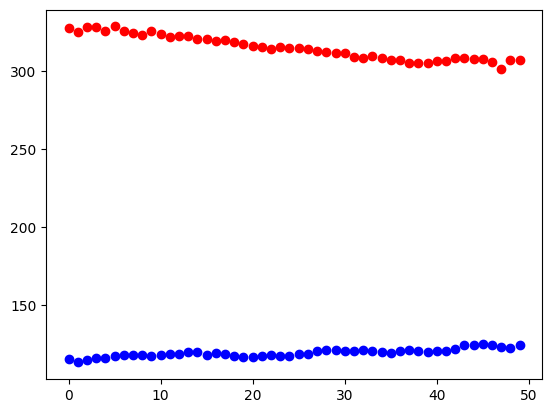

In [25]:
train_loss_solu, val_loss_solu = train(train_set_solu, val_set_solu, 'sol', epochs, num_constraints, num_variables)


x = [i for i in range(epochs)]

plt.plot(x, train_loss_solu, 'o', color='red')
plt.plot(x, val_loss_solu, 'o', color='blue')
plt.show()